In [64]:
import numpy as np

def generate_waveforms(num_sequences, sequence_length, num_modes, freq_range, amp_range, phase_range):
    """
    Generates a dataset of continuous waveforms, each composed of a sum of sinusoidal modes.
    Parameters:
    - num_sequences (int): Number of waveform sequences to generate.
    - sequence_length (int): Number of samples in each waveform sequence.
    - num_modes (int): Number of sinusoidal modes per sequence.
    - freq_range (tuple): Range of frequencies (min_freq, max_freq).
    - amp_range (tuple): Range of amplitudes (min_amp, max_amp).
    - phase_range (tuple): Range of phases (min_phase, max_phase).
    Returns:
    - np.array: Array of shape (num_sequences, sequence_length) containing the generated continuous waveforms.
    """
    waveforms = np.zeros((num_sequences, sequence_length))
    t = np.linspace(0, 2 * np.pi, sequence_length, endpoint=False)
    for i in range(num_sequences):
        for _ in range(num_modes):
            frequency = np.random.uniform(*freq_range)
            amplitude = np.random.uniform(*amp_range)
            phase = np.random.uniform(*phase_range)
            waveforms[i] += amplitude * np.sin(frequency * t + phase)
    return waveforms  # Shape: (num_sequences, sequence_length)

def discretize_waveforms(waveforms, num_bins):
    """
    Discretizes continuous waveforms into one-hot encoded bins after scaling.
    Parameters:
    - waveforms (np.array): Array of continuous waveforms (num_sequences, sequence_length).
    - num_bins (int): Number of bins for discretizing continuous values.
    Returns:
    - np.array: Array of shape (num_sequences, sequence_length, num_bins) containing one-hot encoded waveforms.
    """
    # Normalize the waveform values to [0, num_bins - 1]
    min_val, max_val = waveforms.min(), waveforms.max()
    scaled_waveforms = (waveforms - min_val) / (max_val - min_val) * (num_bins - 1)

    # Discretize to integer bins, ensuring values stay within [0, num_bins - 1]
    discretized_waveforms = np.clip(np.round(scaled_waveforms), 0, num_bins - 1).astype(int)
    
    # Convert to one-hot encoding
    one_hot_waveforms = np.eye(num_bins)[discretized_waveforms]
    
    return one_hot_waveforms  # Shape: (num_sequences, sequence_length, num_bins)


In [65]:
import numpy as np

# Parameters for waveform generation
num_sequences = 1024       # Number of sequences
sequence_length = 128       # Length of each sequence
num_modes = 1              # Number of sinusoidal components
freq_range = (1, 5)         # Frequency range for components
amp_range = (0.5, 1.5)      # Amplitude range for components
phase_range = (0, 2 * np.pi)  # Phase range

# Generate continuous waveforms
waveforms = generate_waveforms(num_sequences, sequence_length, num_modes, freq_range, amp_range, phase_range)

# Discretize waveforms into tokens
num_bins = 32  # Number of bins for tokenizing
discretized_waveforms = discretize_waveforms(waveforms, num_bins)
print("Discretized waveform shape:", discretized_waveforms.shape)

# Convert one-hot encoding to integer tokens
token_sequences = np.argmax(discretized_waveforms, axis=-1)  # Shape: (num_sequences, sequence_length)
print("Token sequences shape:", token_sequences.shape)



Discretized waveform shape: (1024, 128, 32)
Token sequences shape: (1024, 128)


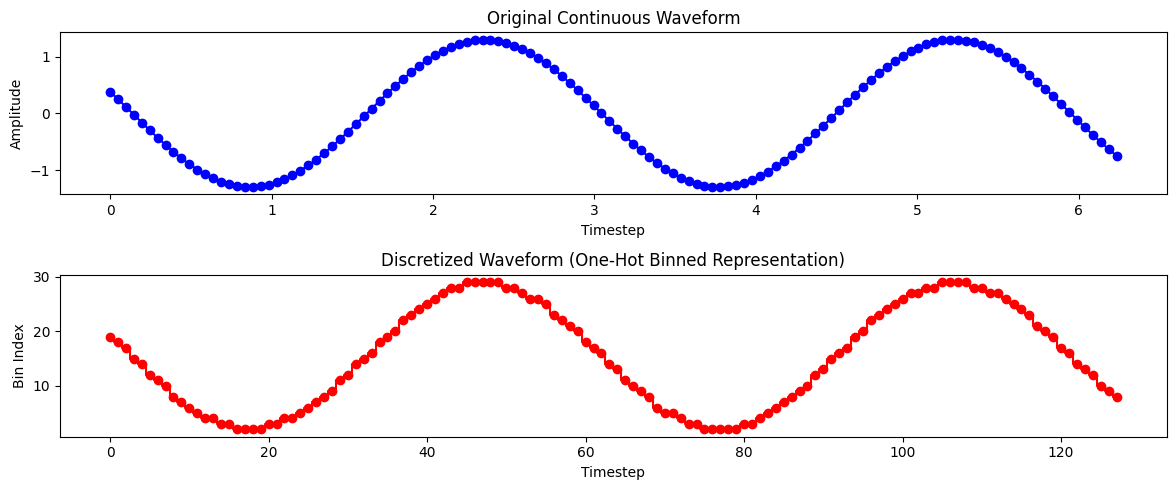

In [66]:
from matplotlib import pyplot as plt
# Extract the continuous waveform and the discretized one-hot version
continuous_waveform = waveforms[0]  # Shape (sequence_length,)
discretized_waveform = np.argmax(discretized_waveforms[0], axis=1)  # Get bin indices for plotting

# Plot the original continuous waveform
plt.figure(figsize=(12, 5))
plt.subplot(2, 1, 1)
plt.plot(np.linspace(0, 2 * np.pi, sequence_length, endpoint=False), continuous_waveform, color='b', marker='o')
plt.title("Original Continuous Waveform")
plt.xlabel("Timestep")
plt.ylabel("Amplitude")

# Plot the discretized one-hot waveform
plt.subplot(2, 1, 2)
plt.step(range(sequence_length), discretized_waveform, where='mid', color='r', marker='o')
plt.title("Discretized Waveform (One-Hot Binned Representation)")
plt.xlabel("Timestep")
plt.ylabel("Bin Index")

plt.tight_layout()

In [67]:
# Step 1: Import Libraries
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Optional, Any, List

In [68]:
from lit_gpt import Config  # Update with correct import path if needed

# Define a smaller configuration
config = Config(
    block_size=128,        # Shorter sequence length for simpler data
    n_layer=4,             # Fewer layers to fit on a single GPU
    n_head=4,              # Fewer attention heads
    n_embd=128,            # Smaller embedding dimension
    rotary_percentage=1.0, # Full rotary embedding for temporal data
    mamba=True,            # Use Mamba for hybrid SSM-attention
    norm_eps=1e-5,
    intermediate_size=256  # Small intermediate size for efficiency
)

In [69]:
# Import and initialize the GPT model
from lit_gpt import GPT  # Update path if needed

# Initialize the model with the custom config
model = GPT(config)

# Print model summary to confirm initialization
print(model)

GPT(
  (lm_head): Linear(in_features=128, out_features=50688, bias=False)
  (transformer): ModuleDict(
    (wte): Embedding(50688, 128)
    (h): ModuleList(
      (0-3): 4 x MBlock(
        (mixer): Mamba(
          (in_proj): Linear(in_features=128, out_features=512, bias=False)
          (conv1d): Conv1d(256, 256, kernel_size=(4,), stride=(1,), padding=(3,), groups=256)
          (act): SiLU()
          (x_proj): Linear(in_features=256, out_features=40, bias=False)
          (dt_proj): Linear(in_features=8, out_features=256, bias=True)
          (out_proj): Linear(in_features=256, out_features=128, bias=False)
        )
        (norm): RMSNorm()
      )
    )
    (ln_f): RMSNorm()
  )
)


In [70]:
from typing import Generator, Tuple, List
import torch
import torch.optim as optim
import torch.nn as nn
from torch import Tensor

def dummy_data_loader(batch_size: int, seq_len: int, num_batches: int = 100) -> Generator[Tensor, None, None]:
    """
    Generate dummy continuous data in the shape of (batch_size, seq_len, 1).
    
    Args:
        batch_size (int): Number of samples per batch.
        seq_len (int): Sequence length for each sample.
        num_batches (int): Total number of batches to generate.
    
    Yields:
        torch.Tensor: Batch of dummy data.
    """
    for _ in range(num_batches):
        yield torch.randn(batch_size, seq_len, 1)  # Shape: (batch_size, seq_len, 1)

def train(model: nn.Module, data_loader: Generator[Tensor, None, None], num_epochs: int = 10, lr: float = 1e-3) -> None:
    """
    Train the model on dummy data.
    
    Args:
        model (nn.Module): Model to be trained.
        data_loader (Generator[Tensor, None, None]): Data loader providing input batches.
        num_epochs (int): Number of training epochs.
        lr (float): Learning rate.
    """
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for batch in data_loader:
            optimizer.zero_grad()
            
            # Forward pass
            output = model(batch[:, :-1, :])  # Input sequence (excluding last timestep)
            loss = criterion(output, batch[:, 1:, :])  # Predict next timestep
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
        
        avg_loss = epoch_loss / num_epochs
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}")

def evaluate(model: nn.Module, data_loader: Generator[Tensor, None, None]) -> float:
    """
    Evaluate the model on dummy data.
    
    Args:
        model (nn.Module): Model to be evaluated.
        data_loader (Generator[Tensor, None, None]): Data loader providing input batches.
    
    Returns:
        float: Average loss over the evaluation data.
    """
    model.eval()
    total_loss = 0.0
    criterion = nn.MSELoss()
    
    with torch.no_grad():
        for batch in data_loader:
            output = model(batch[:, :-1, :])
            loss = criterion(output, batch[:, 1:, :])
            total_loss += loss.item()
    
    avg_loss = total_loss / len(data_loader)
    print(f"Evaluation Loss: {avg_loss:.4f}")
    return avg_loss


In [71]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split

# Convert token sequences to PyTorch tensors
token_sequences_tensor = torch.tensor(token_sequences, dtype=torch.long)

# Define Dataset
dataset = TensorDataset(token_sequences_tensor)

# Split dataset into training and testing sets
train_size = int(0.8 * len(dataset))  # 80% for training
test_size = len(dataset) - train_size  # 20% for testing
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Define DataLoaders for training and testing
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Training samples: {len(train_dataset)}, Testing samples: {len(test_dataset)}")


Training samples: 819, Testing samples: 205


In [ ]:
def train(model: nn.Module, data_loader: DataLoader, num_epochs: int = 10, lr: float = 1e-3) -> None:
    """
    Train the model on tokenized waveform data with shape assertions and labeled sizes.
    
    Args:
        model (nn.Module): Model to be trained.
        data_loader (DataLoader): Data loader providing input batches.
        num_epochs (int): Number of training epochs.
        lr (float): Learning rate.
    """
    # Move the model to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # Define sizes for readability
    vocab_size = model.config.padded_vocab_size  # Vocabulary size for model output
    seq_len = data_loader.dataset[0][0].shape[0]  # Sequence length from dataset
    batch_size = data_loader.batch_size  # Batch size from data loader

    model.train()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()  # Cross-entropy for token prediction

    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for i, batch in enumerate(data_loader):
            batch_size = batch[0].shape[0]  # Update batch size for last batch

            tokens = batch[0].to(device)  # Move tokens to GPU
            assert tokens.shape == (batch_size, seq_len), f"Expected tokens of shape ({batch_size}, {seq_len}), got {tokens.shape}"
            
            optimizer.zero_grad()
            
            # Forward pass
            inputs, targets = tokens[:, :-1], tokens[:, 1:]  # Predict next token
            truncated_seq_len = seq_len - 1
            assert inputs.shape == (batch_size, truncated_seq_len), f"Expected inputs shape ({batch_size}, {truncated_seq_len}), got {inputs.shape}"
            assert targets.shape == (batch_size, truncated_seq_len), f"Expected targets shape ({batch_size}, {truncated_seq_len}), got {targets.shape}"
            
            # Model output
            outputs = model(inputs)
            assert outputs.shape == (batch_size, truncated_seq_len, vocab_size), \
                f"Expected outputs shape ({batch_size}, {truncated_seq_len}, {vocab_size}), got {outputs.shape}"
            
            # Compute loss
            reshaped_outputs = outputs.reshape(-1, vocab_size)
            reshaped_targets = targets.reshape(-1)
            expected_reshaped_size = batch_size * truncated_seq_len
            assert reshaped_outputs.shape == (expected_reshaped_size, vocab_size), \
                f"Expected reshaped_outputs shape ({expected_reshaped_size}, {vocab_size}), got {reshaped_outputs.shape}"
            assert reshaped_targets.shape == (expected_reshaped_size,), \
                f"Expected reshaped_targets shape ({expected_reshaped_size},), got {reshaped_targets.shape}"
            
            loss = criterion(reshaped_outputs, reshaped_targets)
            assert loss.dim() == 0, f"Expected scalar loss, got tensor of shape {loss.shape}"
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        avg_loss = epoch_loss / len(data_loader)
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}")

# Train the model
train(model, train_loader)


32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
19
Epoch [1/10], Loss: 0.5241
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
19
Epoch [2/10], Loss: 0.4069
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
19
Epoch [3/10], Loss: 0.3908
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
19
Epoch [4/10], Loss: 0.3838
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
19
Epoch [5/10], Loss: 0.3800
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
19
Epoch [6/10], Loss: 0.3808
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
19
Epoch [7/10], Loss: 0.3743
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
19
Epoch [8/10], Loss: 0.3669
32
32
32
32
32
32
32
32
32
32
32


KeyboardInterrupt: 